In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.integrate import odeint

eps = np.finfo(float).eps
import copy
import time

ModuleNotFoundError: No module named 'numpy'

# Continuously stirred tank reactor (CSTR)

## Dynamic model

In [ ]:
###############
#  CSTR model #
###############


def cstr(x, t, u1, u2):
    # ==  Inputs (2) == #
    Tc = u1  # Temperature of Cooling Jacket (K)
    Fin = u2  # Volumetric Flowrate at inlet (m^3/sec) = 100

    # == States (5) == #
    Ca = x[0]  # Concentration of A in CSTR (mol/m^3)
    Cb = x[1]  # Concentration of B in CSTR (mol/m^3)
    Cc = x[2]  # Concentration of C in CSTR (mol/m^3)
    T = x[3]  # Temperature in CSTR (K)
    V = x[4]  # Volume in CSTR (K)

    # == Process parameters == #
    Tf = 350  # Feed Temperature (K)
    Caf = 1  # Feed Concentration of A (mol/m^3)
    Fout = 100  # Volumetric Flowrate at outlet (m^3/sec)
    # V       = 100    # Volume of CSTR (m^3)
    rho = 1000  # Density of A-B Mixture (kg/m^3)
    Cp = 0.239  # Heat Capacity of A-B-C Mixture (J/kg-K)
    UA = 5e4  # U -Heat Transfer Coefficient (W/m^2-K) A -Area - (m^2)
    # Reaction A->B
    mdelH_AB = 5e4  # Heat of Reaction for A->B (J/mol)
    EoverR_AB = 8750  # E -Activation Energy (J/mol), R -Constant = 8.31451 J/mol-K
    k0_AB = 7.2e10  # Pre-exponential Factor for A->B (1/sec)#
    rA = k0_AB * np.exp(-EoverR_AB / T) * Ca  # reaction rate
    # Reaction B->C
    mdelH_BC = 5e4  # Heat of Reaction for B->C (J/mol) => 5e4
    EoverR_BC = (
        10750  # E -Activation Energy (J/mol), R -Constant = 8.31451 J/mol-K !! 10
    )
    k0_BC = 8.2e10  # Pre-exponential Factor for A->B (1/sec)# !! 8
    rB = k0_BC * np.exp(-EoverR_BC / T) * Cb  # reaction rate !! **2
    # play with mdelH_BC, factor on Cb**2 and k0_BC, maybe even EoverR_BC

    # == Concentration Derivatives == #
    dCadt = (Fin * Caf - Fout * Ca) / V - rA  # A Concentration Derivative
    dCbdt = rA - rB - Fout * Cb / V  # B Concentration Derivative
    dCcdt = rB - Fout * Cc / V  # B Concentration Derivative
    dTdt = (
        Fin / V * (Tf - T)
        + mdelH_AB / (rho * Cp) * rA
        + mdelH_BC / (rho * Cp) * rB
        + UA / V / rho / Cp * (Tc - T)
    )  # Calculate temperature derivative
    dVdt = Fin - Fout

    # == Return xdot == #
    xdot = np.zeros(5)
    xdot[0] = dCadt
    xdot[1] = dCbdt
    xdot[2] = dCcdt
    xdot[3] = dTdt
    xdot[4] = dVdt
    return xdot

### plot routines

In [ ]:
from pylab import grid

#####################
# Convergence plots #
#####################


def plot_convergence(Xdata, best_Y, Objfunc=None):
    """
    Plots to evaluate the convergence of standard Bayesian optimization algorithms
    """
    ## if f values are not given
    f_best = 1e8
    if best_Y == None:
        best_Y = []
        for i_point in range(Xdata.shape[0]):
            f_point = Objfunc(Xdata[i_point, :])
            if f_point < f_best:
                f_best = f_point
            best_Y.append(f_best)
        best_Y = np.array(best_Y)

    n = Xdata.shape[0]
    aux = (Xdata[1:n, :] - Xdata[0 : n - 1, :]) ** 2
    distances = np.sqrt(aux.sum(axis=1))

    ## Distances between consecutive x's
    plt.figure(figsize=(8, 3))
    plt.subplot(1, 2, 1)
    plt.plot(list(range(n - 1)), distances, "-ro")
    plt.xlabel("Iteration")
    plt.ylabel("d(x[n], x[n-1])")
    plt.title("Distance between consecutive x's")
    grid(True)

    # Estimated m(x) at the proposed sampling points
    plt.subplot(1, 2, 2)
    plt.plot(list(range(n)), best_Y, "-o")
    plt.title("Value of the best selected sample")
    plt.xlabel("Iteration")
    plt.ylabel("Best y")
    # plt.yscale("log")
    grid(True)
    plt.show()


###################################
# control tuning performance plot #
###################################


def plot_result_ct(Ks, data_plot, repetitions):
    # load data
    Ca = copy.deepcopy(data_plot["Ca_ct"])
    V = copy.deepcopy(data_plot["V_ct"])
    Cb = copy.deepcopy(data_plot["Cb_ct"])
    Tc = copy.deepcopy(data_plot["Tc_ct"])
    Cc = copy.deepcopy(data_plot["Cc_ct"])
    Fin = copy.deepcopy(data_plot["Fin_ct"])
    T = copy.deepcopy(data_plot["T_ct"])
    t_c = copy.deepcopy(data_plot["t_c"])
    x0 = copy.deepcopy(data_plot["x0"])
    noise = data_plot["noise"]
    # setpoints
    Cb_des = data_plot["Cb_des"]
    T_des = data_plot["T_des"]
    # upper and lower bounds
    Tc_ub = data_plot["Tc_ub"]
    Tc_lb = data_plot["Tc_lb"]
    Fin_ub = data_plot["Fin_ub"]
    Fin_lb = data_plot["Fin_lb"]

    # creating lists
    Ca_dat = np.zeros((len(t_c), repetitions))
    Fin_dat = np.zeros((len(t_c) - 1, repetitions))
    Cb_dat = np.zeros((len(t_c), repetitions))
    Tc_dat = np.zeros((len(t_c) - 1, repetitions))
    Cc_dat = np.zeros((len(t_c), repetitions))
    error_dat = np.zeros((len(t_c) - 1, repetitions))
    V_dat = np.zeros((len(t_c), repetitions))
    u_mag_dat = np.zeros((len(t_c) - 1, repetitions))
    T_dat = np.zeros((len(t_c), repetitions))
    u_cha_dat = np.zeros((len(t_c) - 2, repetitions))

    # multiple runs
    for rep_i in range(repetitions):
        # re-loading data
        Ca = copy.deepcopy(data_plot["Ca_ct"])
        V = copy.deepcopy(data_plot["V_ct"])
        Cb = copy.deepcopy(data_plot["Cb_ct"])
        Cc = copy.deepcopy(data_plot["Cc_ct"])
        T = copy.deepcopy(data_plot["T_ct"])
        t_c = copy.deepcopy(data_plot["t_c"])
        x0 = copy.deepcopy(data_plot["x0"])
        # initiate
        x = x0
        e_history = []

        # main process simulation loop
        for i in range(len(t_c) - 1):
            # delta t
            ts = [t_c[i], t_c[i + 1]]
            # desired setpoint
            x_sp = np.array([x0[0], Cb_des[i], x0[2], T_des[i], x0[4]])
            # compute control
            if i == 0:
                Tc[i], Fin[i] = PID(
                    Ks, x0, x_sp, np.array([[x0[0], Tc_lb, x0[2], Fin_lb, x0[4]]])
                )
            else:
                Tc[i], Fin[i] = PID(Ks, x0, x_sp, np.array(e_history))
            # simulate reactor
            y = odeint(cstr, x, ts, args=(Tc[i], Fin[i]))
            # adding stochastic behaviour
            s = np.random.normal(0, 0.5, size=5)
            Ca[i + 1] = max([y[-1][0] * (1 + s[0] * 0.01 * noise), 0])
            Cb[i + 1] = max([y[-1][1] * (1 + s[1] * 0.01 * noise), 0])
            Cc[i + 1] = max([y[-1][2] * (1 + s[2] * 0.01 * noise), 0])
            T[i + 1] = max([y[-1][3] * (1 + s[3] * 0.01 * noise), 0])
            V[i + 1] = max([y[-1][4] * (1 + s[4] * 0.01 * noise), 0])
            # state update
            x[0] = Ca[i + 1]
            x[1] = Cb[i + 1]
            x[2] = Cc[i + 1]
            x[3] = T[i + 1]
            x[4] = V[i + 1]
            # compute tracking error
            e_history.append((x_sp - x))

        # == objective == #
        # production
        error = np.abs(
            np.array(e_history)[:, 0]
        )  # +np.abs(np.array(e_history)[:,1])/10
        error = error
        # penalize magnitud of control action
        u_mag = (Tc - Tc_lb) / (12) + (Fin - Fin_lb) / (8)
        u_mag = u_mag / 50
        # penalize change in control action
        # u_cha = np.abs(Tc[1:]-Tc[0:-1])/(12) + np.abs(Fin[1:]-Fin[0:-1])/(8)
        u_cha = (Tc[1:] - Tc[0:-1]) ** 2 / (12) ** 2 + (Fin[1:] - Fin[0:-1]) ** 2 / (
            8
        ) ** 2
        u_cha = u_cha / 50

        # data collection
        Ca_dat[:, rep_i] = copy.deepcopy(Ca)
        Fin_dat[:, rep_i] = copy.deepcopy(Fin)
        Cb_dat[:, rep_i] = copy.deepcopy(Cb)
        Tc_dat[:, rep_i] = copy.deepcopy(Tc)
        Cc_dat[:, rep_i] = copy.deepcopy(Cc)
        error_dat[:, rep_i] = copy.deepcopy(error)
        V_dat[:, rep_i] = copy.deepcopy(V)
        u_mag_dat[:, rep_i] = copy.deepcopy(u_mag)
        T_dat[:, rep_i] = copy.deepcopy(T)
        u_cha_dat[:, rep_i] = copy.deepcopy(u_cha)

    # Plot the results
    plt.figure(figsize=(14, 5))

    plt.subplot(2, 4, 1)
    plt.plot(t_c, np.median(Ca_dat, axis=1), "r-", lw=3)
    plt.gca().fill_between(
        t_c, np.min(Ca_dat, axis=1), np.max(Ca_dat, axis=1), color="r", alpha=0.2
    )
    plt.ylabel("A (mol/m^3)")
    plt.xlabel("Time (min)")
    plt.legend(["Concentration of A in CSTR"], loc="best")

    plt.subplot(2, 4, 2)
    plt.plot(t_c, np.median(Cb_dat, axis=1), "g-", lw=3)
    plt.gca().fill_between(
        t_c, np.min(Cb_dat, axis=1), np.max(Cb_dat, axis=1), color="g", alpha=0.2
    )
    plt.plot(t_c, Cb_des, "--", lw=2)
    plt.ylabel("B (mol/m^3)")
    plt.xlabel("Time (min)")
    plt.legend(["Concentration of B in CSTR"], loc="best")  # Cb_des

    plt.subplot(2, 4, 3)
    plt.plot(t_c, np.median(Cc_dat, axis=1), lw=3)
    plt.gca().fill_between(
        t_c, np.min(Cc_dat, axis=1), np.max(Cc_dat, axis=1), alpha=0.2
    )
    plt.ylabel("C (mol/m^3)")
    plt.xlabel("Time (min)")
    plt.legend(["Concentration of C in CSTR"], loc="best")

    plt.subplot(2, 4, 4)
    plt.plot(t_c, np.median(T_dat, axis=1), "c-", lw=3)
    plt.gca().fill_between(
        t_c, np.min(T_dat, axis=1), np.max(T_dat, axis=1), color="c", alpha=0.2
    )
    plt.ylabel("T (K)")
    plt.xlabel("Time (min)")
    plt.legend(["Reactor Temperature"], loc="best")

    plt.subplot(2, 4, 5)
    plt.plot(t_c, np.median(V_dat, axis=1), "m-", lw=3)
    plt.gca().fill_between(
        t_c, np.min(V_dat, axis=1), np.max(V_dat, axis=1), color="m", alpha=0.2
    )
    plt.ylabel("V (m^3)")
    plt.xlabel("Time (min)")
    plt.legend(["Reactor Volume"], loc="best")

    plt.subplot(2, 4, 6)
    plt.step(t_c[1:], np.median(Tc_dat, axis=1), "b--", lw=3)
    plt.ylabel("Cooling T (K)")
    plt.xlabel("Time (min)")
    plt.legend(["Jacket Temperature"], loc="best")

    plt.subplot(2, 4, 7)
    plt.step(t_c[1:], np.median(Fin_dat, axis=1), "k--", lw=3)
    plt.ylabel("F (m^3/sec)")
    plt.xlabel("Time (min)")
    plt.legend(["Inflow Rate"], loc="best")

    plt.subplot(2, 4, 8)
    plt.plot(t_c[1:], np.median(error_dat, axis=1), "-", lw=3, label="error")
    plt.gca().fill_between(
        t_c[1:], np.min(error_dat, axis=1), np.max(error_dat, axis=1), alpha=0.2
    )
    # plt.plot(t_c[1:],     np.median(u_mag_dat,axis=1), '--', lw=3, label='u_mag')
    # plt.gca().fill_between(t_c[1:], np.min(u_mag_dat,axis=1), np.max(u_mag_dat,axis=1),
    #                       alpha=0.2)
    plt.plot(t_c[2:], np.median(u_cha_dat, axis=1), ".-", lw=3, label="u_cha")
    plt.gca().fill_between(
        t_c[2:], np.min(u_cha_dat, axis=1), np.max(u_cha_dat, axis=1), alpha=0.2
    )
    plt.ylabel("obj function")
    plt.xlabel("Time (min)")
    plt.legend()

    plt.show()

    # print results
    errorsum = np.sum(np.median(error_dat, axis=1))
    u_magsum = np.sum(np.median(u_mag_dat, axis=1))
    u_chasum = np.sum(np.median(u_cha_dat, axis=1))
    print("best result = ", errorsum + u_magsum + u_chasum)


###########################
# b-to-b performance plot #
###########################


def plot_result(u_opt, data_plot, repetitions):
    # loading process operations
    Ca = copy.deepcopy(data_plot["Ca_dat"])
    V = copy.deepcopy(data_plot["V_dat"])
    Cb = copy.deepcopy(data_plot["Cb_dat"])
    x0 = copy.deepcopy(data_plot["x0"])
    Cc = copy.deepcopy(data_plot["Cc_dat"])
    t = copy.deepcopy(data_plot["t"])
    T = copy.deepcopy(data_plot["T_dat"])
    noise = data_plot["noise"]
    n = copy.deepcopy(data_plot["n"])

    # control preparation
    u_opt = np.array(u_opt)
    u_opt = u_opt.reshape(2, n - 1, order="C")
    Tc = u_opt[0, :]
    Fin = u_opt[1, :]
    # creating lists
    Ca_dat = np.zeros((len(t), repetitions))
    Fin_dat = np.zeros((len(t) - 1, repetitions))
    Cb_dat = np.zeros((len(t), repetitions))
    Tc_dat = np.zeros((len(t) - 1, repetitions))
    Cc_dat = np.zeros((len(t), repetitions))
    prod_dat = np.zeros((len(t), repetitions))
    V_dat = np.zeros((len(t), repetitions))
    u_mag_dat = np.zeros((len(t) - 1, repetitions))
    T_dat = np.zeros((len(t), repetitions))
    u_cha_dat = np.zeros((len(t) - 2, repetitions))

    # multiple repetitions
    for rep_i in range(repetitions):
        # re-loading data
        Ca = copy.deepcopy(data_plot["Ca_dat"])
        V = copy.deepcopy(data_plot["V_dat"])
        Cb = copy.deepcopy(data_plot["Cb_dat"])
        Cc = copy.deepcopy(data_plot["Cc_dat"])
        T = copy.deepcopy(data_plot["T_dat"])
        t = copy.deepcopy(data_plot["t"])
        x0 = copy.deepcopy(data_plot["x0"])
        x = x0

        # main process simulation loop
        for i in range(len(t) - 1):
            ts = [t[i], t[i + 1]]
            y = odeint(cstr, x, ts, args=(Tc[i], Fin[i]))
            # adding stochastic behaviour
            s = np.random.normal(0, 0.5, size=5)
            Ca[i + 1] = max([y[-1][0] * (1 + s[0] * 0.01 * noise), 0])
            Cb[i + 1] = max([y[-1][1] * (1 + s[1] * 0.01 * noise), 0])
            Cc[i + 1] = max([y[-1][2] * (1 + s[2] * 0.01 * noise), 0])
            T[i + 1] = max([y[-1][3] * (1 + s[3] * 0.01 * noise), 0])
            V[i + 1] = max([y[-1][4] * (1 + s[4] * 0.01 * noise), 0])
            # state update
            x[0] = Ca[i + 1]
            x[1] = Cb[i + 1]
            x[2] = Cc[i + 1]
            x[3] = T[i + 1]
            x[4] = V[i + 1]

        # production yield
        prod = Cb * V - Cc * V
        # penalize magnitud of control action
        u_mag = np.abs(u_opt[0, :] - 295) / 10 + np.abs(u_opt[1, :] - 97) / 5
        # penalize change in control action
        u_cha = (
            np.abs(u_opt[0, 1:] - u_opt[0, 0:-1]) / 10
            + 2 * np.abs(u_opt[1, 1:] - u_opt[1, 0:-1]) / 5
        )

        # data collection
        Ca_dat[:, rep_i] = copy.deepcopy(Ca)
        Fin_dat[:, rep_i] = copy.deepcopy(Fin)
        Cb_dat[:, rep_i] = copy.deepcopy(Cb)
        Tc_dat[:, rep_i] = copy.deepcopy(Tc)
        Cc_dat[:, rep_i] = copy.deepcopy(Cc)
        prod_dat[:, rep_i] = copy.deepcopy(prod)
        V_dat[:, rep_i] = copy.deepcopy(V)
        u_mag_dat[:, rep_i] = copy.deepcopy(u_mag)
        T_dat[:, rep_i] = copy.deepcopy(T)
        u_cha_dat[:, rep_i] = copy.deepcopy(u_cha)

    # Plot the results
    plt.figure(figsize=(14, 5))

    plt.subplot(2, 4, 1)
    plt.plot(t, np.median(Ca_dat, axis=1), "r-", lw=3)
    plt.gca().fill_between(
        t, np.min(Ca_dat, axis=1), np.max(Ca_dat, axis=1), color="r", alpha=0.2
    )
    plt.ylabel("A (mol/m^3)")
    plt.xlabel("Time (min)")
    plt.legend(["Concentration of A in CSTR"], loc="best")

    plt.subplot(2, 4, 2)
    plt.plot(t, np.median(Cb_dat, axis=1), "g-", lw=3)
    plt.gca().fill_between(
        t, np.min(Cb_dat, axis=1), np.max(Cb_dat, axis=1), color="g", alpha=0.2
    )
    plt.ylabel("B (mol/m^3)")
    plt.xlabel("Time (min)")
    plt.legend(["Concentration of B in CSTR"], loc="best")

    plt.subplot(2, 4, 3)
    plt.plot(t, np.median(Cc_dat, axis=1), lw=3)
    plt.gca().fill_between(t, np.min(Cc_dat, axis=1), np.max(Cc_dat, axis=1), alpha=0.2)
    plt.ylabel("C (mol/m^3)")
    plt.xlabel("Time (min)")
    plt.legend(["Concentration of C in CSTR"], loc="best")

    plt.subplot(2, 4, 4)
    plt.plot(t, np.median(T_dat, axis=1), "c-", lw=3)
    plt.gca().fill_between(
        t, np.min(T_dat, axis=1), np.max(T_dat, axis=1), color="c", alpha=0.2
    )
    plt.ylabel("T (K)")
    plt.xlabel("Time (min)")
    plt.legend(["Reactor Temperature"], loc="best")

    plt.subplot(2, 4, 5)
    plt.plot(t, np.median(V_dat, axis=1), "m-", lw=3)
    plt.gca().fill_between(
        t, np.min(V_dat, axis=1), np.max(V_dat, axis=1), color="m", alpha=0.2
    )
    plt.ylabel("V (m^3)")
    plt.xlabel("Time (min)")
    plt.legend(["Reactor Volume"], loc="best")

    plt.subplot(2, 4, 6)
    plt.step(t[1:], np.median(Tc_dat, axis=1), "b--", lw=3)
    plt.ylabel("Cooling T (K)")
    plt.xlabel("Time (min)")
    plt.legend(["Jacket Temperature"], loc="best")

    plt.subplot(2, 4, 7)
    plt.step(t[1:], np.median(Fin_dat, axis=1), "k--", lw=3)
    plt.ylabel("F (m^3/sec)")
    plt.xlabel("Time (min)")
    plt.legend(["Inflow Rate"], loc="best")

    plt.subplot(2, 4, 8)
    plt.plot(t, np.median(prod_dat, axis=1), "-", lw=3, label="prod")
    plt.gca().fill_between(
        t, np.min(prod_dat, axis=1), np.max(prod_dat, axis=1), alpha=0.2
    )
    plt.plot(t[1:], np.median(u_mag_dat, axis=1) * 10, "--", lw=3, label="u_mag")
    plt.gca().fill_between(
        t[1:], np.min(u_mag_dat, axis=1), np.max(u_mag_dat, axis=1), alpha=0.2
    )
    plt.plot(t[2:], np.median(u_cha_dat, axis=1) * 10, ".-", lw=3, label="u_cha")
    plt.gca().fill_between(
        t[2:], np.min(u_cha_dat, axis=1), np.max(u_cha_dat, axis=1), alpha=0.2
    )
    plt.ylabel("obj function")
    plt.xlabel("Time (min)")
    plt.legend()

    plt.show()

    # print results
    prodsum = np.sum(np.median(prod_dat, axis=1))
    u_magsum = np.sum(np.median(u_mag_dat, axis=1))
    u_chasum = np.sum(np.median(u_cha_dat, axis=1))
    print("best result = ", -prodsum + u_magsum * 10 + u_chasum * 10)


#############################
# self-opt performance plot #
#############################


def plot_self_opt(u_opt, data_plot, repetitions=1):
    n_points = 50
    Tc_p = np.linspace(data_plot["Tc_lb"], data_plot["Tc_ub"], n_points)
    Fin_p = np.linspace(data_plot["Fin_lb"], data_plot["Fin_ub"], n_points)
    f_obj = np.zeros((n_points, n_points))

    for i_tc in range(len(Tc_p)):
        for i_fin in range(len(Fin_p)):
            u_trial = np.array([Tc_p[i_tc], Fin_p[i_fin]])
            f_obj[i_tc, i_fin] = J_SelfOpt(u_trial, data_plot)

    fig, ax = plt.subplots()
    fig.set_size_inches(8, 5)
    CS = ax.contour(Tc_p, Fin_p, f_obj.T, 50)
    ax.plot(u_opt[:, 0], u_opt[:, 1], "ro")
    fig.colorbar(CS)
    ax.set_title("Contour plot")
    plt.show()

## CSTR simulation

In [ ]:
#####################
# process operation #
#####################

data_res = {}
# Initial conditions for the states
x0 = np.zeros(5)
x0[0] = 0.87725294608097  # Initial concentration of A in CSTR (mol/m^3)
x0[1] = 0.0  # Initial concentration of B in CSTR (mol/m^3)
x0[2] = 0.0  # Initial concentration of C in CSTR (mol/m^3)
x0[3] = 324.475443431599  # Initial temperature in CSTR (K)
x0[4] = 100  # Initial volume in CSTR (m^3)
data_res["x0"] = x0

# Time interval (min)
n = 11  # number of intervals
Tf = 25  # process time (min)
t = np.linspace(0, Tf, n)
data_res["t"] = t
data_res["n"] = n

# Store results for plotting
Ca = np.zeros(len(t))
Ca[0] = x0[0]
Cb = np.zeros(len(t))
Cb[0] = x0[1]
Cc = np.zeros(len(t))
Cc[0] = x0[2]
T = np.zeros(len(t))
T[0] = x0[3]
V = np.zeros(len(t))
V[0] = x0[4]
Tc = np.zeros(len(t) - 1)
Fin = np.zeros(len(t) - 1)
data_res["Ca_dat"] = copy.deepcopy(Ca)
data_res["V_dat"] = copy.deepcopy(V)
data_res["Cb_dat"] = copy.deepcopy(Cb)
data_res["Tc_dat"] = copy.deepcopy(Tc)
data_res["Cc_dat"] = copy.deepcopy(Cc)
data_res["Fin_dat"] = copy.deepcopy(Fin)
data_res["T_dat"] = copy.deepcopy(T)
# noise level
noise = 0  # [0,0.1,1]
data_res["noise"] = noise

# control upper and lower bounds
data_res["Tc_ub"] = 302
data_res["Tc_lb"] = 290
data_res["Fin_ub"] = 105
data_res["Fin_lb"] = 97
Tc_ub = data_res["Tc_ub"]
Tc_lb = data_res["Tc_lb"]
Fin_ub = data_res["Fin_ub"]
Fin_lb = data_res["Fin_lb"]

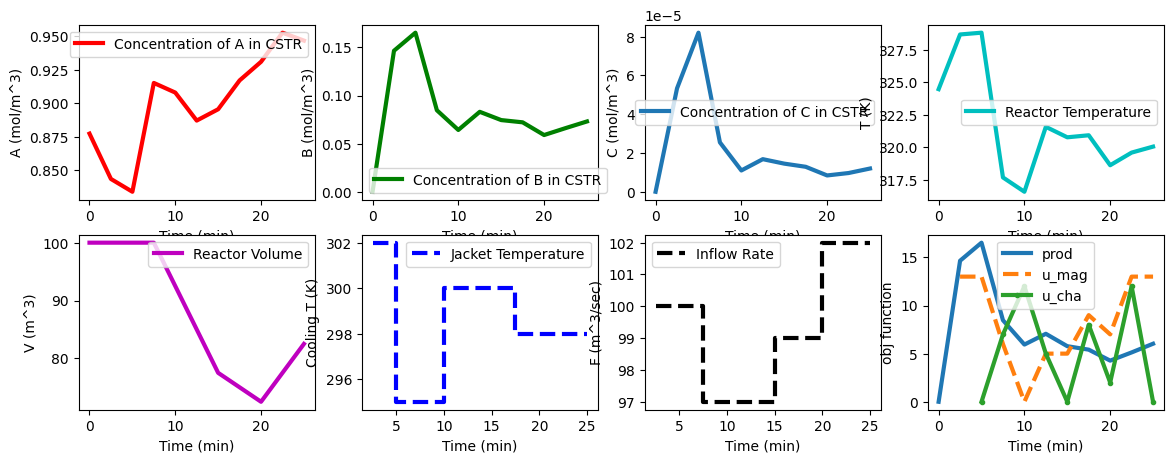

best result =  50.737227291522984


In [ ]:
Tc = np.zeros(len(t) - 1)
Fin = np.zeros(len(t) - 1)
# Step cooling temperature to (295 - 302)
Tc[0:2] = 302.0
Tc[2:4] = 295.0
Tc[4:7] = 300.0
Tc[7:] = 298.0

# Step for volumetric flowrate at inlet (97,102)
Fin[0:3] = 100
Fin[3:6] = 97
Fin[6:8] = 99
Fin[8:] = 102

u_ = np.hstack((Tc, Fin))
# simulate process
plot_result(u_, data_res, 20)

## Constant volume CSTR

This system has the same input and output flow for there to be a steady state.

In [ ]:
###############################
#  CSTR constant volume model #
###############################


def cstr_ss(x, t, u1, u2):
    # ==  Inputs (2) == #
    Tc = u1  # Temperature of Cooling Jacket (K)
    Fin = u2  # Volumetric Flowrate at inlet (m^3/sec) = 100

    # == States (5) == #
    Ca = x[0]  # Concentration of A in CSTR (mol/m^3)
    Cb = x[1]  # Concentration of B in CSTR (mol/m^3)
    Cc = x[2]  # Concentration of C in CSTR (mol/m^3)
    T = x[3]  # Temperature in CSTR (K)
    V = x[4]  # Volume in CSTR (K)

    # == Process parameters == #
    Tf = 350  # Feed Temperature (K)
    Caf = 1  # Feed Concentration of A (mol/m^3)
    Fout = Fin  # Volumetric Flowrate at outlet (m^3/sec)
    # V       = 100    # Volume of CSTR (m^3)
    rho = 1000  # Density of A-B Mixture (kg/m^3)
    Cp = 0.239  # Heat Capacity of A-B-C Mixture (J/kg-K)
    UA = 5e4  # U -Heat Transfer Coefficient (W/m^2-K) A -Area - (m^2)
    # Reaction A->B
    mdelH_AB = 5e4  # Heat of Reaction for A->B (J/mol)
    EoverR_AB = 8750  # E -Activation Energy (J/mol), R -Constant = 8.31451 J/mol-K
    k0_AB = 7.2e10  # Pre-exponential Factor for A->B (1/sec)#
    rA = k0_AB * np.exp(-EoverR_AB / T) * Ca  # reaction rate
    # Reaction B->C
    mdelH_BC = 5e4  # Heat of Reaction for B->C (J/mol) => 5e4
    EoverR_BC = (
        10750  # E -Activation Energy (J/mol), R -Constant = 8.31451 J/mol-K !! 10
    )
    k0_BC = 8.2e10  # Pre-exponential Factor for A->B (1/sec)# !! 8
    rB = k0_BC * np.exp(-EoverR_BC / T) * Cb  # reaction rate !! **2
    # play with mdelH_BC, factor on Cb**2 and k0_BC, maybe even EoverR_BC

    # == Concentration Derivatives == #
    dCadt = (Fin * Caf - Fout * Ca) / V - rA  # A Concentration Derivative
    dCbdt = rA - rB - Fout * Cb / V  # B Concentration Derivative
    dCcdt = rB - Fout * Cc / V  # B Concentration Derivative
    dTdt = (
        Fin / V * (Tf - T)
        + mdelH_AB / (rho * Cp) * rA
        + mdelH_BC / (rho * Cp) * rB
        + UA / V / rho / Cp * (Tc - T)
    )  # Calculate temperature derivative
    dVdt = 0

    # == Return xdot == #
    xdot = np.zeros(5)
    xdot[0] = dCadt
    xdot[1] = dCbdt
    xdot[2] = dCcdt
    xdot[3] = dTdt
    xdot[4] = dVdt
    return xdot

# Data driven optimization algorithms

## ENTMOOT

In [ ]:
!pip install gurobipy
!pip install git+https://github.com/cog-imperial/entmoot
from entmoot.optimizer.optimizer import Optimizer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/cog-imperial/entmoot to /tmp/pip-req-build-na0sd1wa
  Running command git clone --filter=blob:none --quiet https://github.com/cog-imperial/entmoot /tmp/pip-req-build-na0sd1wa
  Resolved https://github.com/cog-imperial/entmoot to commit d3d575815ede829864d6f9ac885762b726ad64b5
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
def opt_ENTMOOT(f, x_dim, bounds, iter_tot):
    """
    params: parameters that define the rbf model
    X:      matrix of previous datapoints
    """

    opt = Optimizer(
        bounds,
        base_estimator="ENTING",
        n_initial_points=int(iter_tot * 0.2),
        initial_point_generator="random",
        acq_func="LCB",
        acq_optimizer="sampling",
        random_state=100,
        model_queue_size=None,
        base_estimator_kwargs={"lgbm_params": {"min_child_samples": 1}},
        verbose=False,
    )

    # run optimizer for 20 iterations
    res = opt.run(f, n_iter=iter_tot)

    return res.x, res.fun, res

## Powell

In [ ]:
#########################
# --- Random search --- #
#########################

# (f, N_x: int, bounds: array[array[float]], N: int = 100) -> array(N_X), float
def Random_search(f, n_p, bounds_rs, iter_rs):
    """
    This function is a naive optimization routine that randomly samples the
    allowed space and returns the best value.

    This is used to find a good starting point for Powell
    """

    # arrays to store sampled points
    localx = np.zeros((n_p, iter_rs))  # points sampled
    localval = np.zeros((iter_rs))  # function values sampled
    # bounds
    bounds_range = bounds_rs[:, 1] - bounds_rs[:, 0]
    bounds_bias = bounds_rs[:, 0]

    for sample_i in range(iter_rs):
        x_trial = np.random.uniform(0, 1, n_p) * bounds_range + bounds_bias  # sampling
        localx[:, sample_i] = x_trial
        localval[sample_i] = f(x_trial)  # f
    # choosing the best
    minindex = np.argmin(localval)
    f_b = localval[minindex]
    x_b = localx[:, minindex]

    return f_b, x_b


#########################
# --- Powell Method --- #
#########################


# (f, N_x: int, bounds: array[array[float]], N: int = 100) -> array(N_X), float
def opt_Powell(f, x_dim, bounds, iter_tot):
    """
    params: parameters that define the rbf model
    X:      matrix of previous datapoints
    """

    n_rs = int(
        min(100, max(iter_tot * 0.05, 5))
    )  # iterations to find good starting point

    # evaluate first point
    f_best, x_best = Random_search(f, x_dim, bounds, n_rs)
    iter_ = iter_tot - n_rs

    opt = minimize(f, x_best, bounds=bounds, method="Powell", options={"maxfev": iter_})

    print("-- optimization results -- ")
    print(opt)

    return opt.x, opt.fun

## Bayesian optimization

In [ ]:
!pip install gpyopt
import GPyOpt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
def opt_GPyOpt(f, x_dim, bounds, iter_tot):
    """
    params: parameters that define the rbf model
    X:      matrix of previous datapoints
    """

    bounds_GPyOpt = [
        {
            "name": "var_" + str(i + 1),
            "type": "continuous",
            "domain": (bounds[i, 0], bounds[i, 1]),
        }
        for i in range(len(bounds))
    ]

    myBopt = GPyOpt.methods.BayesianOptimization(f, domain=bounds_GPyOpt)
    myBopt.run_optimization(max_iter=iter_tot)
    # results
    myBopt.plot_convergence()
    print("objective f = ", myBopt.fx_opt)

    return myBopt.x_opt, myBopt.fx_opt, myBopt

## PyBOBYQA

In [ ]:
!pip install Py-BOBYQA
import pybobyqa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
def opt_PyBOBYQA(f, x_dim, bounds, iter_tot):
    """
    params: parameters that define the rbf model
    X:      matrix of previous datapoints
    """

    # iterations to find good starting point
    n_rs = 5

    # evaluate first point
    f_best, x_best = Random_search(f, x_dim, bounds, n_rs)
    iter_ = iter_tot - n_rs

    # restructure bounds
    a = bounds[:, 0]
    b = bounds[:, 1]
    pybobyqa_bounds = (a, b)
    other_outputs = {}

    soln = pybobyqa.solve(
        f,
        x_best,
        seek_global_minimum=True,
        objfun_has_noise=True,
        user_params={
            "restarts.use_restarts": True,
            "logging.save_diagnostic_info": True,
            "logging.save_xk": True,
        },
        maxfun=iter_,
        bounds=pybobyqa_bounds,
        rhobeg=0.1 * 20,
    )

    other_outputs["soln"] = soln
    other_outputs["x_all"] = np.array(soln.diagnostic_info["xk"].tolist())

    return soln.x, f(soln.x), other_outputs


# for full results or more info
# https://numericalalgorithmsgroup.github.io/pybobyqa/build/html/userguide.html#a-simple-example

# Controller Tuning

## Process operation

In [ ]:
#############################
# process control operation #
#############################

# Time interval (min)
n_c = 101  # 41#21 # 11
Tf_c = 30  # 30 # process time (min) 25
t_c = np.linspace(0, Tf_c, n_c)
data_res["t_c"] = t_c

# desired setpoints
n_1 = int(n_c / 2)
n_2 = n_c - n_1
Cb_des = [0.2 for i in range(n_1)] + [0.2 for i in range(n_2)]
T_des = [330 for i in range(n_1)] + [325 for i in range(n_2)]
data_res["Cb_des"] = Cb_des
data_res["T_des"] = T_des

# Store results for plotting
Ca = np.zeros(len(t_c))
Ca[0] = copy.deepcopy(x0[0])
Cb = np.zeros(len(t_c))
Cb[0] = copy.deepcopy(x0[1])
Cc = np.zeros(len(t_c))
Cc[0] = copy.deepcopy(x0[2])
T = np.zeros(len(t_c))
T[0] = copy.deepcopy(x0[3])
V = np.zeros(len(t_c))
V[0] = copy.deepcopy(x0[4])
Tc = np.zeros(len(t_c) - 1)
Fin = np.zeros(len(t_c) - 1)
data_res["Ca_ct"] = copy.deepcopy(Ca)
data_res["V_ct"] = copy.deepcopy(V)
data_res["Cb_ct"] = copy.deepcopy(Cb)
data_res["Tc_ct"] = copy.deepcopy(Tc)
data_res["Cc_ct"] = copy.deepcopy(Cc)
data_res["Fin_ct"] = copy.deepcopy(Fin)
data_res["T_ct"] = copy.deepcopy(T)

## PID controller

In [ ]:
##################
# PID controller #
##################


def PID(Ks, x, x_setpoint, e_history):
    Ks = np.array(Ks)
    Ks = Ks.reshape(32, order="C")
    # u_T gains for Ca, Cb, T, V, and bias
    KpCbT = Ks[0]
    KiCbT = Ks[1]
    KdCbT = Ks[2]
    KpTT = Ks[3]
    KiTT = Ks[4]
    KdTT = Ks[5]
    KpCaT = Ks[6]
    KiCaT = Ks[7]
    KdCaT = Ks[8]
    KpCcT = Ks[9]
    KiCcT = Ks[10]
    KdCcT = Ks[11]
    KpVT = Ks[12]
    KiVT = Ks[13]
    KdVT = Ks[14]
    KT = Ks[15]
    # u_F K gains for Ca, Cb, T, V, and bias
    KpCbF = Ks[16]
    KiCbF = Ks[17]
    KdCbF = Ks[18]
    KpTF = Ks[19]
    KiTF = Ks[20]
    KdTF = Ks[21]
    KpCaF = Ks[22]
    KiCaF = Ks[23]
    KdCaF = Ks[24]
    KpCcF = Ks[25]
    KiCcF = Ks[26]
    KdCcF = Ks[27]
    KpVF = Ks[28]
    KiVF = Ks[29]
    KdVF = Ks[30]
    KF = Ks[31]

    # setpoint error
    e = x_setpoint - x

    # control action Tc
    u_T = (
        KpCbT * e[1] + KiCbT * sum(e_history[:, 1]) + KdCbT * (e[1] - e_history[-1, 1])
    )
    u_T += KpTT * e[3] + KiTT * sum(e_history[:, 3]) + KdTT * (e[3] - e_history[-1, 3])
    u_T += KpTT * e[0] + KiTT * sum(e_history[:, 0]) + KdTT * (e[0] - e_history[-1, 0])
    u_T += KpTT * e[2] + KiTT * sum(e_history[:, 2]) + KdTT * (e[2] - e_history[-1, 2])
    u_T += KpTT * e[4] + KiTT * sum(e_history[:, 4]) + KdTT * (e[4] - e_history[-1, 4])
    u_T += KT
    u_T = min(max(u_T, Tc_lb), Tc_ub)

    # control action Fin
    u_F = (
        KpCbF * e[0] + KiCbF * sum(e_history[:, 0]) + KdCbF * (e[1] - e_history[-1, 0])
    )
    u_F += KpTF * e[3] + KiTF * sum(e_history[:, 3]) + KdTF * (e[3] - e_history[-1, 3])
    u_F += KpTF * e[0] + KiTF * sum(e_history[:, 0]) + KdTF * (e[0] - e_history[-1, 0])
    u_F += KpTF * e[2] + KiTF * sum(e_history[:, 2]) + KdTF * (e[2] - e_history[-1, 2])
    u_F += KpTF * e[4] + KiTF * sum(e_history[:, 4]) + KdTF * (e[4] - e_history[-1, 4])
    u_F += KF
    u_F = min(max(u_F, Fin_lb), Fin_ub)

    return u_T, u_F

## Objective function: control

In [ ]:
def J_ControlCSTR(Ks, data_res=data_res, full_output=False):
    # load data
    Ca = copy.deepcopy(data_res["Ca_ct"])
    V = copy.deepcopy(data_res["V_ct"])
    Cb = copy.deepcopy(data_res["Cb_ct"])
    Tc = copy.deepcopy(data_res["Tc_ct"])
    Cc = copy.deepcopy(data_res["Cc_ct"])
    Fin = copy.deepcopy(data_res["Fin_ct"])
    T = copy.deepcopy(data_res["T_ct"])
    t_c = copy.deepcopy(data_res["t_c"])
    x0 = copy.deepcopy(data_res["x0"])
    noise = data_res["noise"]
    # setpoints
    Cb_des = data_res["Cb_des"]
    T_des = data_res["T_des"]
    # upper and lower bounds
    Tc_ub = data_res["Tc_ub"]
    Tc_lb = data_res["Tc_lb"]
    Fin_ub = data_res["Fin_ub"]
    Fin_lb = data_res["Fin_lb"]

    # initiate
    x = x0
    e_history = []
    # main loop
    for i in range(len(t_c) - 1):
        # delta t
        ts = [t_c[i], t_c[i + 1]]
        # desired setpoint
        x_sp = np.array([x0[0], Cb_des[i], x0[2], T_des[i], x0[4]])
        # compute control
        if i == 0:
            Tc[i], Fin[i] = PID(
                Ks, x, x_sp, np.array([[x0[0], Tc_lb, x0[2], Fin_lb, x0[4]]])
            )
        else:
            Tc[i], Fin[i] = PID(Ks, x, x_sp, np.array(e_history))
        # simulate reactor
        y = odeint(cstr, x, ts, args=(Tc[i], Fin[i]))
        # adding stochastic behaviour
        s = np.random.normal(0, 0.5, size=5)
        Ca[i + 1] = max([y[-1][0] * (1 + s[0] * 0.01 * noise), 0])
        Cb[i + 1] = max([y[-1][1] * (1 + s[1] * 0.01 * noise), 0])
        Cc[i + 1] = max([y[-1][2] * (1 + s[2] * 0.01 * noise), 0])
        T[i + 1] = max([y[-1][3] * (1 + s[3] * 0.01 * noise), 0])
        V[i + 1] = max([y[-1][4] * (1 + s[4] * 0.01 * noise), 0])
        # state update
        x[0] = Ca[i + 1]
        x[1] = Cb[i + 1]
        x[2] = Cc[i + 1]
        x[3] = T[i + 1]
        x[4] = V[i + 1]
        # compute tracking error
        e_history.append(x_sp - x)

    # == objective == #
    # production
    error = np.abs(np.array(e_history)[:, 1])  # +np.abs(np.array(e_history)[:,1])/10
    # penalize magnitud of control action
    u_mag = (Tc - Tc_lb) / (12) + (Fin - Fin_lb) / (8)
    u_mag = u_mag / 50
    # penalize change in control action
    # u_cha = np.abs(Tc[1:]-Tc[0:-1])/(12) + np.abs(Fin[1:]-Fin[0:-1])/(8)
    u_cha = (Tc[1:] - Tc[0:-1]) ** 2 / (12) ** 2 + (Fin[1:] - Fin[0:-1]) ** 2 / (8) ** 2
    u_cha = u_cha / 50

    if full_output:
        # == outputs == #
        return t_c, Ca, Cb, Cc, T, V, Tc, Fin, error, u_mag, u_cha
    else:
        # == objective == #
        error = np.sum(error)
        u_mag = np.sum(u_mag)
        u_cha = np.sum(u_cha)
        return error + u_cha  # + u_mag

### Process Control: Powell

In [ ]:
iter_tot = 100

boundsK = np.array(
    [[0.0, 5.0]] * 6
    + [[-2, 2]] * 9
    + [[0.0, Tc_lb]]
    + [[0.0, 5.0]] * 6
    + [[-2, 2]] * 9
    + [[0.0, Fin_lb]]
)

start_time = time.time()
Kpowell, f_opt = opt_Powell(J_ControlCSTR, int(32), boundsK, iter_tot)
end_time = time.time()

print("this optimization took ", end_time - start_time, " (s)")
print("Ks = ", Kpowell)

-- optimization results -- 
 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 1
     fun: 4.897544141416431
       x: [ 3.198e+00  2.245e+00 ... -1.392e-01  7.484e+01]
     nit: 0
   direc: [[ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
           [ 0.000e+00  1.000e+00 ...  0.000e+00  0.000e+00]
           ...
           [ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]
           [ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]]
    nfev: 95
this optimization took  6.658923149108887  (s)
Ks =  [ 3.19849245e+00  2.24478433e+00  1.90989318e+00  2.70599612e+00
  2.71168275e+00  3.12799805e-03 -7.81646554e-01  7.40856502e-02
  1.05571759e+00  1.55304673e+00 -1.72632806e+00  1.29556596e+00
 -5.37673191e-01 -1.79013445e+00  9.43898476e-01  1.27714022e+02
  1.30927842e+00  8.52313952e-01  2.82097906e-01  3.22302663e+00
  4.66592042e+00  4.67876474e+00 -1.17277130e+00  3.04420123e-01
 -1.22539795e+00 -1.36504829e-01 -7.64441088e-02 -5.30579905

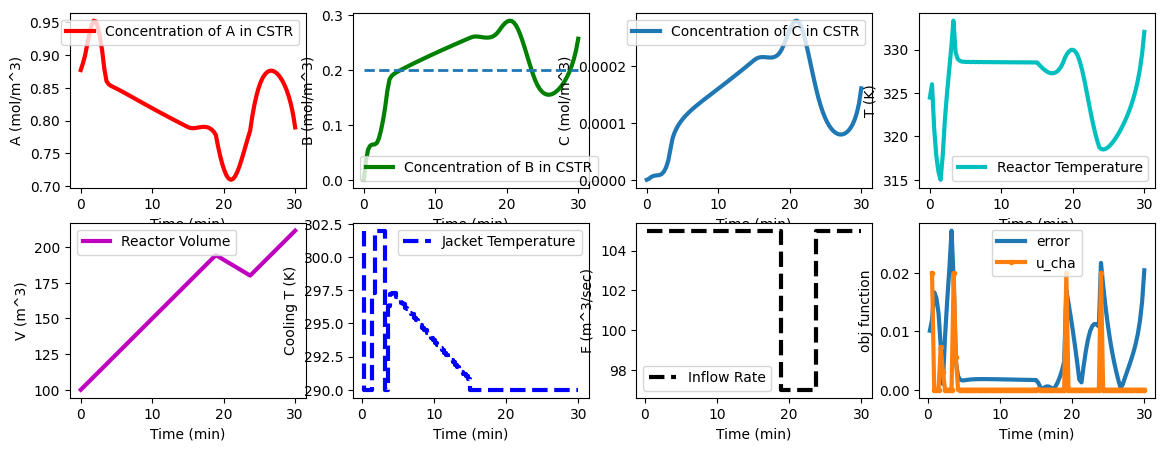

best result =  2.7489570538045505


In [ ]:
plot_result_ct(Kpowell, data_res, 3)

### Process Control: ENTMOOT

100%|██████████| 100/100 [01:33<00:00,  1.07it/s]


this optimization took  93.67195725440979  (s)


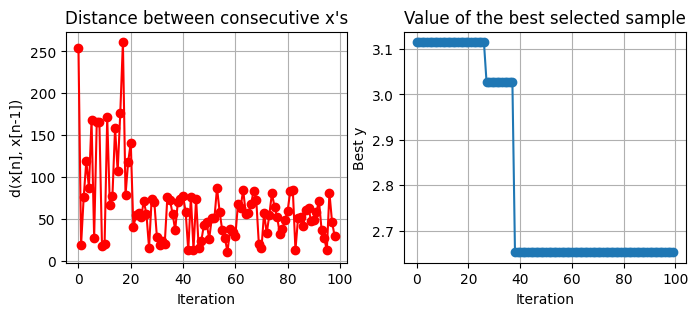

Convergence plot does not include initial points to fit first surrogate


In [ ]:
iter_tot = 100

boundsK = np.array(
    [[0.0, 5.0]] * 6
    + [[-2, 2]] * 9
    + [[0.0, Tc_lb]]
    + [[0.0, 5.0]] * 6
    + [[-2, 2]] * 9
    + [[0.0, Fin_lb]]
)

start_time = time.time()
Kentmoot, f_opt, res = opt_ENTMOOT(J_ControlCSTR, 32, boundsK, iter_tot)
end_time = time.time()

print("this optimization took ", end_time - start_time, " (s)")

plot_convergence(np.array(res["x_iters"]), None, J_ControlCSTR)

print("Convergence plot does not include initial points to fit first surrogate")

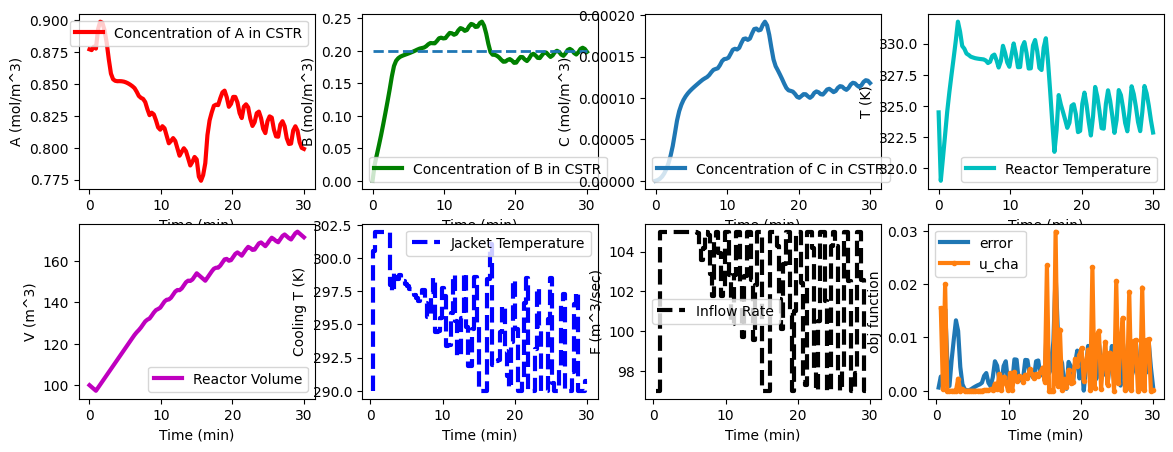

best result =  3.0246184896538244


In [ ]:
plot_result_ct(Kentmoot, data_res, 3)

### Process Control: BOBYQA

In [ ]:
iter_tot = 100

boundsK = np.array(
    [[0.0, 5.0]] * 6
    + [[-2, 2]] * 9
    + [[0.0, Tc_lb]]
    + [[0.0, 5.0]] * 6
    + [[-2, 2]] * 9
    + [[0.0, Fin_lb]]
)

start_time = time.time()
Kbobyqa, f_opt, other_outputs = opt_PyBOBYQA(J_ControlCSTR, 32, boundsK, iter_tot)
end_time = time.time()

print("this optimization took ", end_time - start_time, " (s)")

plot_convergence(other_outputs["x_all"], None, J_ControlCSTR)

print("Convergence plot does not include initial points to fit first surrogate")

this optimization took  4.159548282623291  (s)


IndexError: ignored

In [ ]:
plot_result_ct(Kbobyqa, data_res, 3)

### ProcessControl: Bayesian optimization

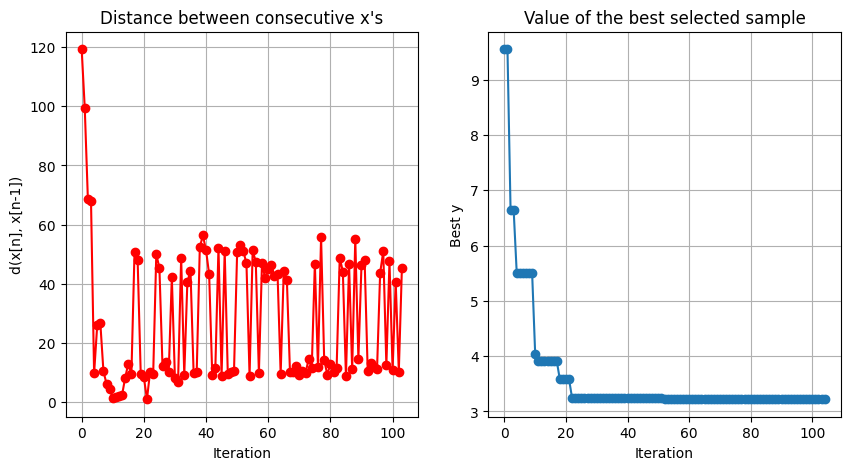

objective f =  3.220113099219836
this optimization took  111.66978073120117  (s)


In [ ]:
iter_tot = 100

boundsK = np.array(
    [[0.0, 5.0]] * 6
    + [[-2, 2]] * 9
    + [[0.0, Tc_lb]]
    + [[0.0, 5.0]] * 6
    + [[-2, 2]] * 9
    + [[0.0, Fin_lb]]
)

start_time = time.time()
Kgpopt, f_opt, Bopt = opt_GPyOpt(J_ControlCSTR, 32, boundsK, iter_tot)
end_time = time.time()

print("this optimization took ", end_time - start_time, " (s)")

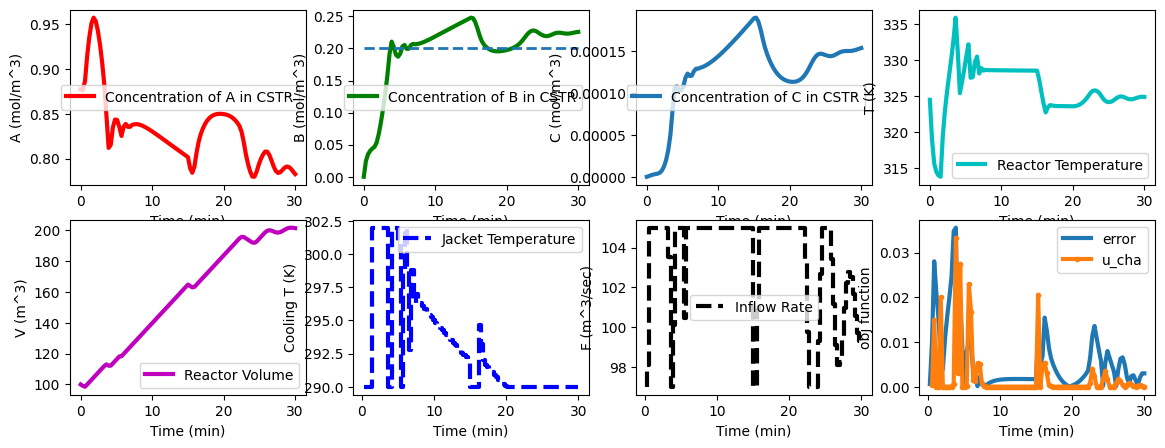

best result =  2.865904402237374


In [ ]:
plot_result_ct(Kgpopt, data_res, 3)

# Batch-to-batch dynamic optimizing

## Process operation

In [ ]:
############################
# b-to-b process operation #
############################

# Other operations not specified earlier
Tc_ub = data_res["Tc_ub"]
Tc_lb = data_res["Tc_lb"]
Fin_ub = data_res["Fin_ub"]
Fin_lb = data_res["Fin_lb"]

## Objective function: b-to-b

In [ ]:
def J_OptCSTR(u, data_res=data_res, full_output=False):
    # load data
    Ca = copy.deepcopy(data_res["Ca_dat"])
    V = copy.deepcopy(data_res["V_dat"])
    Cb = copy.deepcopy(data_res["Cb_dat"])
    Tc = copy.deepcopy(data_res["Tc_dat"])
    Cc = copy.deepcopy(data_res["Cc_dat"])
    Fin = copy.deepcopy(data_res["Fin_dat"])
    T = copy.deepcopy(data_res["T_dat"])
    t = copy.deepcopy(data_res["t"])
    x0 = copy.deepcopy(data_res["x0"])
    n = copy.deepcopy(data_res["n"])

    # control preparation
    u = np.array(u)
    u = u.reshape(2, n - 1, order="C")

    noise = data_res["noise"]
    x = x0
    for i in range(len(t) - 1):
        # delta t
        ts = [t[i], t[i + 1]]
        # control update
        Tc[i] = u[0, i]
        Fin[i] = u[1, i]
        # simulate reactor
        y = odeint(cstr, x, ts, args=(Tc[i], Fin[i]))
        # adding stochastic behaviour
        s = np.random.normal(0, 0.5, size=5)
        Ca[i + 1] = max([y[-1][0] * (1 + s[0] * 0.03 * noise), 0])
        Cb[i + 1] = max([y[-1][1] * (1 + s[1] * 0.03 * noise), 0])
        Cc[i + 1] = max([y[-1][2] * (1 + s[2] * 0.03 * noise), 0])
        T[i + 1] = max([y[-1][3] * (1 + s[3] * 0.03 * noise), 0])
        V[i + 1] = max([y[-1][4] * (1 + s[4] * 0.03 * noise), 0])
        # state update
        x[0] = Ca[i + 1]
        x[1] = Cb[i + 1]
        x[2] = Cc[i + 1]
        x[3] = T[i + 1]
        x[4] = V[i + 1]

    # == objective == #
    # production
    prod = np.sum(Cb * V - Cc * V)
    # penalize magnitud of control action
    u_mag = np.abs(u[0, :] - 295) / 10 + np.abs(u[1, :] - 97) / 5
    # penalize change in control action
    u_cha = np.abs(u[0, 1:] - u[0, 0:-1]) / 10 + 2 * np.abs(u[1, 1:] - u[1, 0:-1]) / 5

    if full_output:
        # == outputs == #
        return t, Ca, Cb, Cc, T, V, u, prod, u_mag, u_cha
    else:
        # == objective == #
        prod = np.sum(prod)
        u_mag = np.sum(u_mag)
        u_cha = np.sum(u_cha)
        return -prod + u_mag * 10 + u_cha * 10

### b-to-b: ENTMOOT

100%|██████████| 100/100 [01:08<00:00,  1.47it/s]


this optimization took  68.05133271217346  (s)


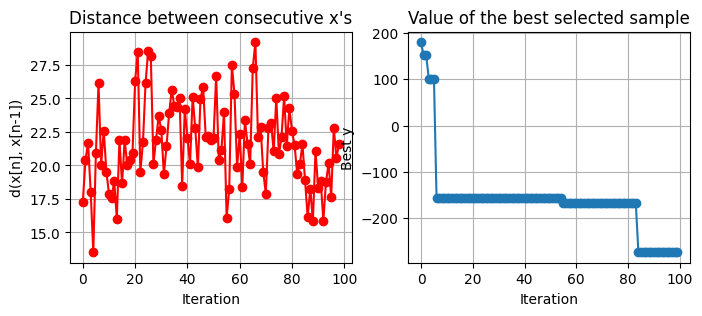

Convergence plot does not include initial points to fit first surrogate


In [ ]:
iter_tot = 100

boundsu = np.array([[Tc_lb, Tc_ub]] * (n - 1) + [[Fin_lb, Fin_ub]] * (n - 1))

start_time = time.time()
u_opt, f_opt, res = opt_ENTMOOT(J_OptCSTR, int(2 * (n - 1)), boundsu, iter_tot)
end_time = time.time()

print("this optimization took ", end_time - start_time, " (s)")

plot_convergence(np.array(res["x_iters"]), None, J_OptCSTR)

print("Convergence plot does not include initial points to fit first surrogate")

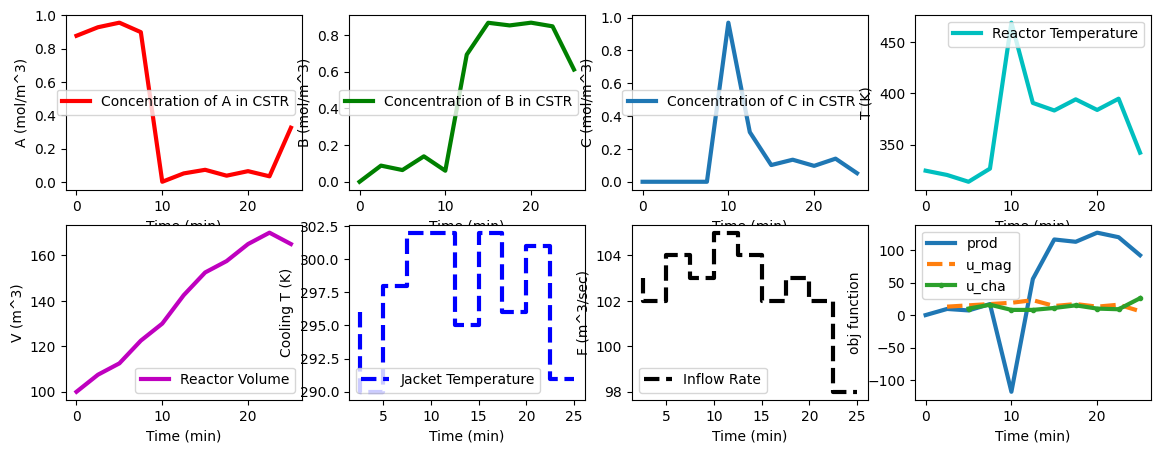

best result =  -273.9280879424589


In [ ]:
plot_result(u_opt, data_res, 20)

### b-to-b: Powell

In [ ]:
iter_tot = 100

boundsu = np.array([[Tc_lb, Tc_ub]] * (n - 1) + [[Fin_lb, Fin_ub]] * (n - 1))

start_time = time.time()
u_opt, f_opt = opt_Powell(J_OptCSTR, int(2 * (n - 1)), boundsu, iter_tot)
end_time = time.time()

print("this optimization took ", end_time - start_time, " (s)")

-- optimization results -- 
 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 1
     fun: 96.62629021822053
       x: [ 2.993e+02  2.993e+02 ...  9.916e+01  9.950e+01]
     nit: 0
   direc: [[ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
           [ 0.000e+00  1.000e+00 ...  0.000e+00  0.000e+00]
           ...
           [ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]
           [ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]]
    nfev: 95
this optimization took  0.832082986831665  (s)


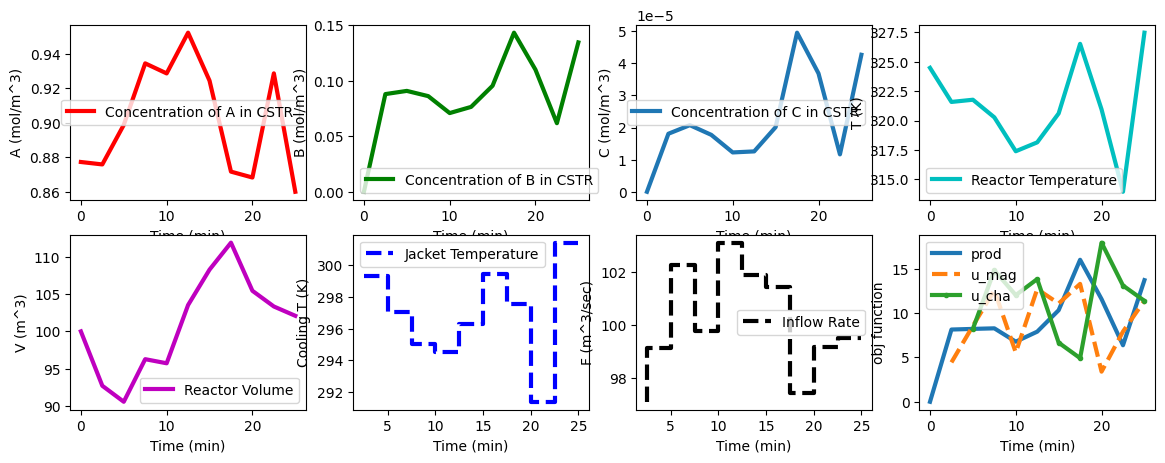

best result =  96.62629021822053


In [ ]:
plot_result(u_opt, data_res, 20)

### b-to-b: BOBYQA

In [ ]:
iter_tot = 100

boundsu = np.array([[Tc_lb, Tc_ub]] * (n - 1) + [[Fin_lb, Fin_ub]] * (n - 1))

start_time = time.time()
u_opt, f_opt, other_outputs = opt_PyBOBYQA(
    J_OptCSTR, int(2 * (n - 1)), boundsu, iter_tot
)
end_time = time.time()

print("this optimization took ", end_time - start_time, " (s)")

plot_convergence(other_outputs["x_all"], None, J_OptCSTR)

print("Convergence plot does not include initial points to fit first surrogate")

this optimization took  2.058145761489868  (s)


IndexError: ignored

In [ ]:
plot_result(u_opt, data_res, 20)

### b-to-b: Bayesian optimization

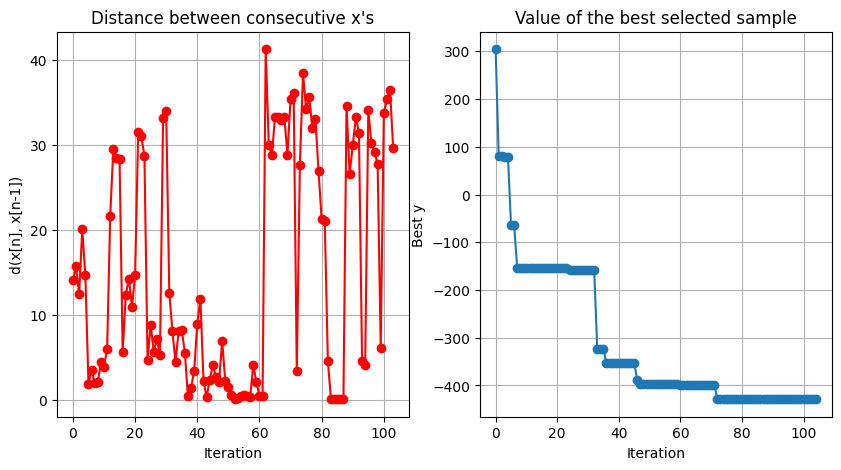

objective f =  -428.83853195541144
this optimization took  445.8481321334839  (s)


In [ ]:
iter_tot = 100

boundsu = np.array([[Tc_lb, Tc_ub]] * (n - 1) + [[Fin_lb, Fin_ub]] * (n - 1))

start_time = time.time()
u_opt, f_opt, Bopt = opt_GPyOpt(J_OptCSTR, int(2 * (n - 1)), boundsu, iter_tot)
end_time = time.time()

print("this optimization took ", end_time - start_time, " (s)")

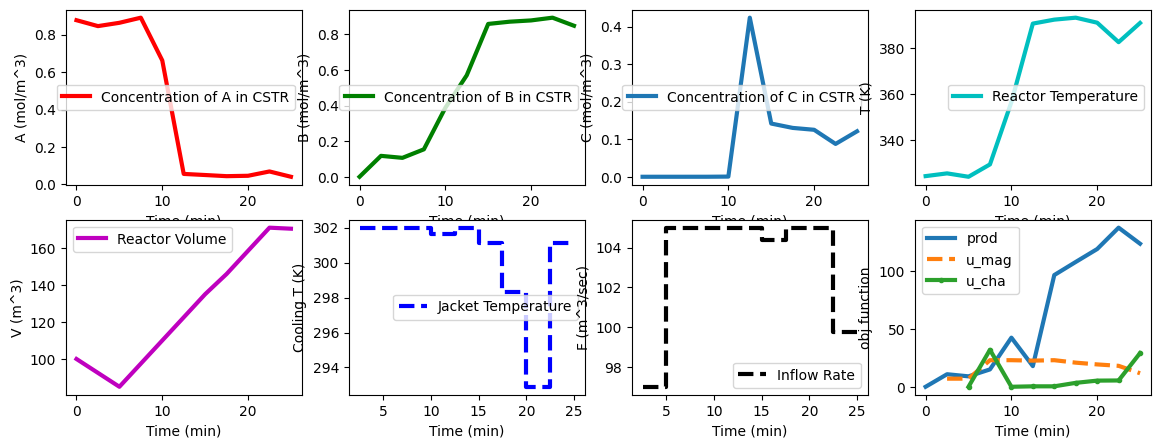

best result =  -428.83853195541144


In [ ]:
plot_result(u_opt, data_res, 20)

# Self optimizing reactor

In [ ]:
from scipy.optimize import fsolve  # this solves for the steady state

#############################
# Self optimization reactor #
#############################

# Other operations not specified earlier
Tc_ub = data_res["Tc_ub"]
Tc_lb = data_res["Tc_lb"]
Fin_ub = data_res["Fin_ub"]
Fin_lb = data_res["Fin_lb"]

In [ ]:
###############################
#  CSTR constant volume model #
###############################


def cstr_ss(x, t, u1, u2):
    # ==  Inputs (2) == #
    Tc = u1  # Temperature of Cooling Jacket (K)
    Fin = u2  # Volumetric Flowrate at inlet (m^3/sec) = 100

    # == States (5) == #
    Ca = x[0]  # Concentration of A in CSTR (mol/m^3)
    Cb = x[1]  # Concentration of B in CSTR (mol/m^3)
    Cc = x[2]  # Concentration of C in CSTR (mol/m^3)
    T = x[3]  # Temperature in CSTR (K)
    V = x[4]  # Volume in CSTR (K)

    # == Process parameters == #
    Tf = 350  # Feed Temperature (K)
    Caf = 1  # Feed Concentration of A (mol/m^3)
    Fout = Fin  # Volumetric Flowrate at outlet (m^3/sec)
    # V       = 100    # Volume of CSTR (m^3)
    rho = 1000  # Density of A-B Mixture (kg/m^3)
    Cp = 0.239  # Heat Capacity of A-B-C Mixture (J/kg-K)
    UA = 5e4  # U -Heat Transfer Coefficient (W/m^2-K) A -Area - (m^2)
    # Reaction A->B
    mdelH_AB = 5e4  # Heat of Reaction for A->B (J/mol)
    EoverR_AB = 8750  # E -Activation Energy (J/mol), R -Constant = 8.31451 J/mol-K
    k0_AB = 7.2e10  # Pre-exponential Factor for A->B (1/sec)#
    rA = k0_AB * np.exp(-EoverR_AB / T) * Ca  # reaction rate
    # Reaction B->C
    mdelH_BC = 5e4  # Heat of Reaction for B->C (J/mol) => 5e4
    EoverR_BC = (
        10750  # E -Activation Energy (J/mol), R -Constant = 8.31451 J/mol-K !! 10
    )
    k0_BC = 8.2e10  # Pre-exponential Factor for A->B (1/sec)# !! 8
    rB = k0_BC * np.exp(-EoverR_BC / T) * Cb  # reaction rate !! **2
    # play with mdelH_BC, factor on Cb**2 and k0_BC, maybe even EoverR_BC

    # == Concentration Derivatives == #
    dCadt = (Fin * Caf - Fout * Ca) / V - rA  # A Concentration Derivative
    dCbdt = rA - rB - Fout * Cb / V  # B Concentration Derivative
    dCcdt = rB - Fout * Cc / V  # B Concentration Derivative
    dTdt = (
        Fin / V * (Tf - T)
        + mdelH_AB / (rho * Cp) * rA
        + mdelH_BC / (rho * Cp) * rB
        + UA / V / rho / Cp * (Tc - T)
    )  # Calculate temperature derivative
    dVdt = 0

    # == Return xdot == #
    xdot = np.zeros(5)
    xdot[0] = dCadt
    xdot[1] = dCbdt
    xdot[2] = dCcdt
    xdot[3] = dTdt
    xdot[4] = dVdt
    return xdot

## Objective function: self-optimization

In [ ]:
def J_SelfOpt(u, data_res=data_res, full_output=False):
    # load data
    x0 = copy.deepcopy(data_res["x0"])
    noise = data_res["noise"]
    Tc_ub = data_res["Tc_ub"]
    Tc_lb = data_res["Tc_lb"]
    Fin_ub = data_res["Fin_ub"]
    Fin_lb = data_res["Fin_lb"]

    # control preparation
    u = np.array(u)
    u = u.reshape(2, 1)
    # solve for steady state
    eq = fsolve(cstr_ss, x0, args=(0, u[0, :], u[1, :]))
    # steady states
    Ca = eq[0]
    Cb = eq[1]
    Cc = eq[2]
    T = eq[3]
    V = eq[4]

    # == objective == #
    # production
    yield_ss = Cb - Cc * 1e3
    # penalize magnitud of control action
    u_mag = ((u[0, :] - Tc_lb) / 3) ** 2 + ((u[1, :] - Fin_lb) / 15) ** 2

    return (-yield_ss + u_mag / 100)[0]

### self-opt: Bayesian optimization

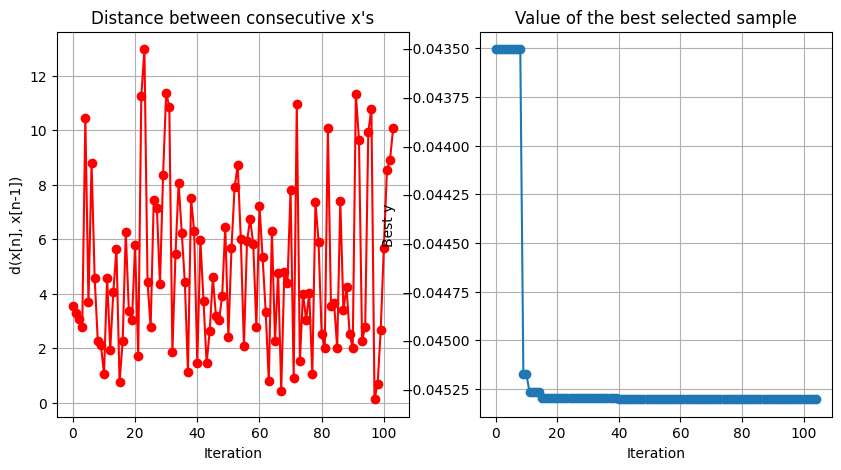

objective f =  -0.045302428056888534
this optimization took  121.69561052322388  (s)


In [ ]:
iter_tot = 100

boundsu = np.array([[Tc_lb, Tc_ub]] + [[Fin_lb, Fin_ub]])

start_time = time.time()
u_opt_gpyopt, f_optz, Bopt = opt_GPyOpt(J_SelfOpt, 2, boundsu, iter_tot)
end_time = time.time()

print("this optimization took ", end_time - start_time, " (s)")

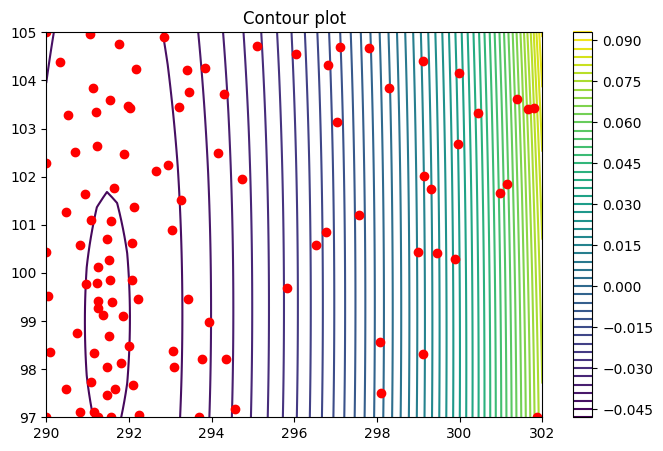

In [ ]:
plot_self_opt(Bopt.get_evaluations()[0], data_res, repetitions=1)

### self-opt: BOBYQA

In [ ]:
iter_tot = 100

boundsu = np.array([[Tc_lb, Tc_ub]] + [[Fin_lb, Fin_ub]])

start_time = time.time()
u_opt_gpyopt, f_opt, other_outputs = opt_PyBOBYQA(J_SelfOpt, 2, boundsu, iter_tot)
end_time = time.time()

print("this optimization took ", end_time - start_time, " (s)")

plot_convergence(other_outputs["x_all"], None, J_SelfOpt)

print(
    "Convergence plot for BOBYQA does not include initial points to fit first surrogate"
)

AssertionError: ignored

In [ ]:
plot_self_opt(other_outputs["x_all"], data_res, repetitions=1)

### self-opt: ENTMOOT

In [ ]:
iter_tot = 100

boundsu = np.array([[Tc_lb, Tc_ub]] + [[Fin_lb, Fin_ub]])

start_time = time.time()
u_opt, f_opt, res = opt_ENTMOOT(J_SelfOpt, 2, boundsu, iter_tot)
end_time = time.time()

print("this optimization took ", end_time - start_time, " (s)")

plot_convergence(np.array(res["x_iters"]), None, J_SelfOpt)

In [ ]:
plot_self_opt(np.array(res["x_iters"]), data_res, repetitions=1)

### self-opt: Powell

In [ ]:
iter_tot = 100

boundsu = np.array([[Tc_lb, Tc_ub]] + [[Fin_lb, Fin_ub]])

start_time = time.time()
u_opt_powell, f_opt = opt_Powell(J_SelfOpt, 2, boundsu, iter_tot)
end_time = time.time()

print("this optimization took ", end_time - start_time, " (s)")

In [ ]:
plot_self_opt(u_opt_powell.reshape(1, 2), data_res, repetitions=1)

print("Plot for Powell only includes the last point")

# Parallel Experiment design for reactor optimization

In [ ]:
xdim = 2
iter_tot = 5
batch_size = 3
bounds = np.array([[Tc_lb, Tc_ub]] + [[Fin_lb, Fin_ub]])
init_ndata = 3
# initial points to sample
X_init = np.random.uniform(low=0, high=1, size=(init_ndata, xdim))
X_init = X_init * (bounds[:, 1] - bounds[:, 0]) + bounds[:, 0]
# initial evaluation of 'experiments'
Y_init = []
for x_i in X_init:
    Y_init.append(J_SelfOpt(x_i))
Y_init = np.array(Y_init)
print("X_init = ", X_init)
print("Y_init = ", Y_init)

In [ ]:
bounds[:, 1] - bounds[:, 0]

In [ ]:
xdim = 2
iter_tot = 5
batch_size = 3
bounds = np.array([[Tc_lb, Tc_ub]] + [[Fin_lb, Fin_ub]])
init_ndata = 3
# initial points to sample
X_init = np.random.uniform(low=0, high=1, size=(init_ndata, xdim))
X_init = X_init * (bounds[:, 1] - bounds[:, 0]) + bounds[:, 0]
# initial evaluation of 'experiments'
Y_init = []
for x_i in X_init:
    Y_init.append(J_SelfOpt(x_i))
Y_init = np.array(Y_init)


iter_tot = 10
current_iter = 0
X_step = X_init
Y_step = Y_init

while current_iter < iter_tot:
    BO_parallel = GPyOpt.methods.BayesianOptimization(
        f=None,
        domain=bounds_GPyOpt,
        acquisition_type="EI",
        evaluator_type="local_penalization",
        batch_size=batch_size,
        X=X_step,
        Y=Y_step,
    )
    x_next = BO_parallel.suggest_next_locations()
    y_next = []
    for x_i in x_next:
        y_next.append(Rosenbrock_f(x_i))
    y_next = np.array([y_next])
    y_next = y_next.T
    X_step = np.vstack((X_step, x_next))
    Y_step = np.vstack((Y_step, y_next))

    current_iter += 1